Resources:
- [Hands-On Graph Neural Networks Using Python - Maxime Labonne](https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python)

In [20]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.5 MB/s eta 0:00:00:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 8.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done


In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
import torch_geometric.nn as geo_nn
from torch_geometric.datasets import Planetoid, FacebookPagePage
import torch_geometric.transforms as geo_T
import torch_geometric.utils as geo_utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import os
from tqdm import tqdm
import networkx as nx
import gc
from collections import Counter

print("imports done!")

imports done!


In [145]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")


def accuracy(y_pred, y_true):
    """Calculate accuracy"""
    return torch.sum(y_pred == y_true) / len(y_true)

In [36]:
get_torch_version()

2.6

In [37]:
set_seed()

seed 42 set!


## Fundamental Graph Neural Network Architectures (🕸️+🏠)

- **Graph Datasets** 👪
- **Neural Network (NN)** 🧠
- **Vanilla Graph Neural Network (GNN)** 🍦
- **Graph Convolutional Network (GCN)** 🖼️
- **Graph Attention Network (GAT)** 🚗
- **Message Passing Neural Network (MPNN) - Generalization of GNN** 📟

## Graph Datasets 👪

#### Cora (Node classification)

- A node indicates a publication.
    - A node embedding is a binary vector of 1433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word.
- An edge indicates a reference.
- Goal = classify each node into one of 7 classes.

In [31]:
dataset1 = Planetoid(root=".", name="Cora")
data1 = dataset1[0]

In [102]:
print(f'Dataset: {dataset1}')
print('---------------')
print(f'Number of graphs: {len(dataset1)}')
print(f'Number of nodes: {data1.x.shape[0]}')
print(f'Number of features: {dataset1.num_features}')
print(f'Number of classes: {dataset1.num_classes}')
print("Feature vector shape:\t", data1.x.shape)
print("Edge index shape:\t", data1.edge_index.shape)
print("Edge embedding shape:\t", data1.edge_attr)   # there is no edge embedding
print("Target vector shape:\t", data1.y.shape)

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Feature vector shape:	 torch.Size([2708, 1433])
Edge index shape:	 torch.Size([2, 10556])
Edge embedding shape:	 None
Target vector shape:	 torch.Size([2708])


In [33]:
print(f'Graph:')
print('------')
print(f'Edges are directed: {data1.is_directed()}')
print(f'Graph has isolated nodes: {data1.has_isolated_nodes()}')
print(f'Graph has self loops: {data1.has_self_loops()}')

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [47]:
classes1 = {
    0: "Case Based",
    1: "Genetic Algorithms",
    2: "Neural Networks",
    3: "Probabilistic Methods",
    4: "Reinforcement Learning",
    5: "Rule Learning",
    6: "Theory"
}

In [73]:
def fn(idx=0):
    print("Feature vector:\t", data1.x[idx])
    print("Target:\t\t", classes1[data1.y[idx].item()])


fn(29)

Feature vector:	 tensor([0., 0., 0.,  ..., 0., 0., 0.])
Target:		 Reinforcement Learning


In [80]:
print("Train dataset size:\t", data1.train_mask.shape)
print("Valid dataset size:\t", data1.val_mask.shape)
print("Test dataset size:\t", data1.test_mask.shape)

Train dataset size:	 torch.Size([2708])
Valid dataset size:	 torch.Size([2708])
Test dataset size:	 torch.Size([2708])


#### FacebookPagePage (Node classification)

- A node indicates a Facebook page.
    - A node embedding is created by textual description of the page by the owner of the page.
- 2 pages are connected (ie, edge is present) both the pages like each other. So, an edge indicates a mutual like.
- Goal = classify each node into one of 4 classes.

In [39]:
dataset2 = FacebookPagePage(root=".")
data2 = dataset2[0]

Processing...
Done!


In [110]:
print(f'Dataset: {dataset2}')
print('---------------')
print(f'Number of graphs: {len(dataset2)}')
print(f'Number of nodes: {data2.x.shape[0]}')
print(f'Number of features: {dataset2.num_features}')
print(f'Number of classes: {dataset2.num_classes}')
print("Node embedding shape:\t", data2.x.shape)
print("Edge index shape:\t", data2.edge_index.shape)
print("Edge embedding shape:\t", data2.edge_attr)   # there is no edge embedding
print("Target vector shape:\t", data2.y.shape)

Dataset: FacebookPagePage()
---------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4
Node embedding shape:	 torch.Size([22470, 128])
Edge index shape:	 torch.Size([2, 342004])
Edge embedding shape:	 None
Target vector shape:	 torch.Size([22470])


In [41]:
print(f'Graph:')
print('------')
print(f'Edges are directed: {data2.is_directed()}')
print(f'Graph has isolated nodes: {data2.has_isolated_nodes()}')
print(f'Graph has self loops: {data2.has_self_loops()}')

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has self loops: True


In [48]:
classes2 = {
    0: "Politician",
    1: "Governmental Organization",
    2: "Television show",
    3: "Company"
}

In [74]:
def fn(idx=0):
    print("Feature vector:\t", data2.x[idx])
    print("Target:\t", classes2[data2.y[idx].item()])


fn(29)

Feature vector:	 tensor([-0.2580, -0.2765, -0.2624, -0.2955, -0.2992, -0.2707, -0.3078, -0.2697,
        -0.2397, -0.3083, -0.3702, -0.2257, -0.3020, -0.4484, -0.3127, -0.2246,
        -0.2658, -0.3512, -0.2864, -0.1716,  4.5486, -0.2405, -0.3133, -0.2233,
        -0.2109, -0.4077, -0.2733, -0.2454, -0.2727, -0.2096, -0.2025, -0.3140,
        -0.2657, -0.4149, -0.1894, -0.2183, -0.3146, -0.3444, -0.2709, -0.2077,
        -0.3012, -0.3117, -0.1762, -0.2389, -0.1885, -0.1912, -0.2558, -0.2034,
        -0.2479, -0.2715, -0.3031, -0.2617, -0.2262, -0.3022, -0.3071, -0.1727,
        -0.2784, -0.3083, -0.3605, -0.2487, -0.2801, -0.2067, -0.2428, -0.3063,
        -0.2261, -0.2407, -0.2257, -0.2204, -0.2196, -0.2343, -0.1427,  3.7775,
        -0.2787, -0.1535, -0.1822, -0.2439, -0.2701, -0.2878, -0.1846, -0.2401,
        -0.2520, -0.2323, -0.2742,  2.1950, -0.2763, -0.1981, -0.1880, -0.3621,
        -0.2370, -0.2380, -0.3073, -0.2643, -0.2724, -0.2327, -0.2046, -0.2470,
        -0.3129, -0.116

In [82]:
# FacebookPagePage dataset doesn't have train, val, and test masks by default 
# so, we'll create them manually
data2.train_mask = range(18000)
data2.val_mask = range(18001, 20000)
data2.test_mask = range(20001, 22470)
print("Train dataset size:\t", data2.train_mask)
print("Valid dataset size:\t", data2.val_mask)
print("Test dataset size:\t", data2.test_mask)

Train dataset size:	 range(0, 18000)
Valid dataset size:	 range(18001, 20000)
Test dataset size:	 range(20001, 22470)


## Neural Network (NN) 🧠

<figure>
  <div style="text-align: center;">
  <img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/06/Artificial-Neuron-Working.gif" alt="Artificial Neuron" width="700"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>Artificial Neuron</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://machinelearningknowledge.ai/animated-explanation-of-feed-forward-neural-network-architecture/">Animated Explanation of Feed Forward Neural Network Architecture - Ankur K.</a>
  </p>
  </figcaption>
</figure>

<br> <br>

<figure>
  <div style="text-align: center;">
  <img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif" alt="Artificial Neuron" width="700"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>Feed Forword Network and Backpropagation</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://machinelearningknowledge.ai/animated-explanation-of-feed-forward-neural-network-architecture/">Animated Explanation of Feed Forward Neural Network Architecture - Ankur K.</a>
  </p>
  </figcaption>
</figure>

In [95]:
# # Converting the graph datasets to tabular datasets (to apply regular neural network)
# df1 = pd.DataFrame(data1.x.numpy())
# df1["target"] = pd.DataFrame(data1.y)
# df1

In [84]:
df2 = pd.DataFrame(data2.x.numpy())
df2["target"] = pd.DataFrame(data2.y)
df2

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,target
0,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,0
1,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.234818,-0.223700,-0.284379,-0.197935,-0.147256,-0.255755,-0.215140,-0.364134,-0.128634,2
2,-0.262576,-0.265053,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.210461,-0.25101,3.222161,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,1
3,-0.246378,-0.276483,-0.241991,-0.299327,-0.299159,-0.270681,-0.307051,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.265534,-0.080353,-0.209509,-0.250560,-0.180260,-0.375903,-0.223836,2
4,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.175312,-0.272613,-0.224216,-0.181153,-0.255755,-0.215140,-0.370639,-0.223836,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22465,-0.262576,-0.276483,-0.262350,-0.296955,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.196685,-0.370115,-0.223836,3
22466,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.221643,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,1
22467,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.146793,-0.255755,-0.180389,-0.372097,-0.222613,2
22468,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307668,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.252456,-0.215140,-0.375903,-0.218148,1


In [121]:
class MLP(nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(dim_in, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in tqdm(range(epochs+1)):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    # @torch.no_grad()
    def test(self, data):
        with torch.inference_mode():
            self.eval()
            out = self(data.x)
            acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc
        

mlp1 = MLP(dataset1.num_features, 16, dataset1.num_classes)
print(mlp1)
print("\n")
mlp2 = MLP(dataset2.num_features, 16, dataset2.num_classes)
print(mlp2)

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)


MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)


In [123]:
# Train
mlp1.fit(data1, epochs=100)

# Test
acc_mlp1 = mlp.test(data1)
print(f'\nMLP test accuracy: {acc_mlp1*100:.2f}%')

 26%|██▌       | 26/101 [00:00<00:00, 126.03it/s]

Epoch   0 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.35 | Val Acc: 53.20%
Epoch  20 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.35 | Val Acc: 55.00%


 53%|█████▎    | 54/101 [00:00<00:00, 131.38it/s]

Epoch  40 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 52.80%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 53.60%


100%|██████████| 101/101 [00:00<00:00, 130.07it/s]

Epoch  80 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.38 | Val Acc: 53.60%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.38 | Val Acc: 53.80%

MLP test accuracy: 51.70%


In [124]:
# Train
mlp2.fit(data2, epochs=100)

# Test
acc_mlp2 = mlp2.test(data2)
print(f'\nMLP test accuracy: {acc_mlp2*100:.2f}%')

  5%|▍         | 5/101 [00:00<00:04, 22.90it/s]

Epoch   0 | Train Loss: 1.341 | Train Acc: 36.19% | Val Loss: 1.34 | Val Acc: 36.82%


 26%|██▌       | 26/101 [00:00<00:02, 28.00it/s]

Epoch  20 | Train Loss: 0.650 | Train Acc: 74.62% | Val Loss: 0.67 | Val Acc: 73.54%


 47%|████▋     | 47/101 [00:01<00:01, 29.78it/s]

Epoch  40 | Train Loss: 0.570 | Train Acc: 77.32% | Val Loss: 0.62 | Val Acc: 74.79%


 66%|██████▋   | 67/101 [00:02<00:01, 29.72it/s]

Epoch  60 | Train Loss: 0.543 | Train Acc: 78.32% | Val Loss: 0.60 | Val Acc: 75.14%


 84%|████████▍ | 85/101 [00:02<00:00, 29.38it/s]

Epoch  80 | Train Loss: 0.527 | Train Acc: 79.05% | Val Loss: 0.59 | Val Acc: 75.94%


100%|██████████| 101/101 [00:03<00:00, 28.68it/s]

Epoch 100 | Train Loss: 0.514 | Train Acc: 79.67% | Val Loss: 0.59 | Val Acc: 76.14%

MLP test accuracy: 75.94%


## Vanilla Graph Neural Network (GNN) 🍦

In [111]:
class VanillaGNNLayer(nn.Module):
    """Graph Linear Layer."""
    def __init__(self, dim_in, dim_out):
        super(VanillaGNNLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        # adjacency matrix gives the GNN information about nodes and edges, ie, network topology
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x
        

In [142]:
adjacency1_gnn = geo_utils.to_dense_adj(data1.edge_index)[0]
adjacency1_gnn += torch.eye(len(adjacency1_gnn))
print(adjacency1_gnn)
print(adjacency1_gnn.shape)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
torch.Size([2708, 2708])


In [143]:
adjacency2_gnn = geo_utils.to_dense_adj(data2.edge_index)[0]
adjacency2_gnn += torch.eye(len(adjacency2_gnn))
print(adjacency2_gnn)
print(adjacency2_gnn.shape)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
torch.Size([22470, 22470])


In [144]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


In [132]:
class VanillaGNN(nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, adjacency, epochs):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(),
                               lr=0.01,
                               weight_decay=5e-4)

        self.train()
        for epoch in tqdm(range(epochs+1)):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                           data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    # @torch.no_grad()
    def test(self, data, adjacency):
        with torch.inference_mode():
            self.eval()
            out = self(data.x, adjacency)
            acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


In [133]:
vanilla_gnn1 = VanillaGNN(dataset1.num_features, 16, dataset1.num_classes)
vanilla_gnn2 = VanillaGNN(dataset2.num_features, 16, dataset2.num_classes)
print(vanilla_gnn1)
print("\n")
print(vanilla_gnn2)

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)


VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)


In [134]:
# Train
vanilla_gnn1.fit(data1, adjacency1_gnn, epochs=100)

# Test
acc_vanilla_gnn1 = vanilla_gnn1.test(data1, adjacency1_gnn)
print(f'\nGNN test accuracy: {acc_vanilla_gnn1*100:.2f}%')

  8%|▊         | 8/101 [00:00<00:02, 34.64it/s]

Epoch   0 | Train Loss: 2.226 | Train Acc: 14.29% | Val Loss: 2.17 | Val Acc: 12.60%


 24%|██▍       | 24/101 [00:00<00:02, 32.02it/s]

Epoch  20 | Train Loss: 0.104 | Train Acc: 99.29% | Val Loss: 1.48 | Val Acc: 71.00%


 47%|████▋     | 47/101 [00:01<00:01, 30.66it/s]

Epoch  40 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.84 | Val Acc: 72.80%


 62%|██████▏   | 63/101 [00:02<00:01, 31.50it/s]

Epoch  60 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.97 | Val Acc: 74.00%


 86%|████████▌ | 87/101 [00:02<00:00, 30.85it/s]

Epoch  80 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.00 | Val Acc: 74.40%


100%|██████████| 101/101 [00:03<00:00, 31.52it/s]

Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.99 | Val Acc: 74.80%

GNN test accuracy: 76.90%


In [135]:
# Train
vanilla_gnn2.fit(data2, adjacency2_gnn, epochs=100)

# Test
acc_vanilla_gnn2 = vanilla_gnn2.test(data2, adjacency2_gnn)
print(f'\nGNN test accuracy: {acc_vanilla_gnn2*100:.2f}%')

  1%|          | 1/101 [00:01<02:28,  1.48s/it]

Epoch   0 | Train Loss: 132.298 | Train Acc: 36.58% | Val Loss: 113.47 | Val Acc: 36.87%


 21%|██        | 21/101 [00:31<02:05,  1.57s/it]

Epoch  20 | Train Loss: 6.123 | Train Acc: 81.53% | Val Loss: 4.13 | Val Acc: 82.49%


 41%|████      | 41/101 [01:01<01:28,  1.47s/it]

Epoch  40 | Train Loss: 3.023 | Train Acc: 84.94% | Val Loss: 2.09 | Val Acc: 84.59%


 60%|██████    | 61/101 [01:29<00:55,  1.39s/it]

Epoch  60 | Train Loss: 1.366 | Train Acc: 84.47% | Val Loss: 1.08 | Val Acc: 83.74%


 80%|████████  | 81/101 [01:57<00:27,  1.38s/it]

Epoch  80 | Train Loss: 1.575 | Train Acc: 84.96% | Val Loss: 1.24 | Val Acc: 84.99%


100%|██████████| 101/101 [02:27<00:00,  1.46s/it]

Epoch 100 | Train Loss: 0.906 | Train Acc: 85.06% | Val Loss: 0.84 | Val Acc: 84.84%



GNN test accuracy: 84.97%


## Graph Convolutional Network (GCN) 🖼️



<figure>
  <div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/90/CNN-filter-animation-1.gif?20230201202141" alt="convolution" width="700"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b><strong>Applying a convolution filter</strong></b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://commons.wikimedia.org/wiki/File:CNN-filter-animation-1.gif">Wikimedia Commons</a>
  </p>
  </figcaption>
</figure>


In [152]:
class GCN(nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.gcn1 = geo_nn.GCNConv(dim_in, dim_h)
        self.gcn2 = geo_nn.GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
        self.train()
        for epoch in tqdm(range(epochs+1)):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    # @torch.no_grad()
    def test(self, data):
        with torch.inference_mode():
            self.eval()
            out = self(data.x, data.edge_index)
            acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


gcn1 = GCN(dataset1.num_features, 16, dataset1.num_classes)
gcn2 = GCN(dataset2.num_features, 16, dataset2.num_classes)
print(gcn1)
print("\n")
print(gcn2)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)


In [150]:
# Train
gcn1.fit(data1, epochs=100)

# Test
acc_gcn1 = gcn1.test(data1)
print(f'\nGCN test accuracy: {acc_gcn1*100:.2f}%\n')

 14%|█▍        | 14/101 [00:00<00:01, 69.56it/s]

Epoch   0 | Train Loss: 1.943 | Train Acc: 15.00% | Val Loss: 1.95 | Val Acc: 17.80%


 30%|██▉       | 30/101 [00:00<00:00, 71.68it/s]

Epoch  20 | Train Loss: 0.111 | Train Acc: 100.00% | Val Loss: 0.79 | Val Acc: 77.40%


 53%|█████▎    | 54/101 [00:00<00:00, 70.42it/s]

Epoch  40 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.80 | Val Acc: 76.40%


 69%|██████▉   | 70/101 [00:01<00:00, 67.87it/s]

Epoch  60 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 77.20%


 93%|█████████▎| 94/101 [00:01<00:00, 71.08it/s]

Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%


100%|██████████| 101/101 [00:01<00:00, 69.72it/s]

Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 76.80%

GCN test accuracy: 79.60%



In [153]:
# Train
gcn2.fit(data2, epochs=100)

# Test
acc_gcn2 = gcn2.test(data2)
print(f'\nGCN test accuracy: {acc_gcn2*100:.2f}%\n')

  2%|▏         | 2/101 [00:00<00:14,  6.63it/s]

Epoch   0 | Train Loss: 1.534 | Train Acc: 23.52% | Val Loss: 1.53 | Val Acc: 24.76%


 21%|██        | 21/101 [00:02<00:10,  7.42it/s]

Epoch  20 | Train Loss: 0.455 | Train Acc: 84.02% | Val Loss: 0.45 | Val Acc: 83.94%


 42%|████▏     | 42/101 [00:05<00:09,  6.26it/s]

Epoch  40 | Train Loss: 0.324 | Train Acc: 89.25% | Val Loss: 0.32 | Val Acc: 89.79%


 61%|██████▏   | 62/101 [00:08<00:04,  8.63it/s]

Epoch  60 | Train Loss: 0.278 | Train Acc: 91.14% | Val Loss: 0.28 | Val Acc: 91.40%


 81%|████████  | 82/101 [00:10<00:02,  8.52it/s]

Epoch  80 | Train Loss: 0.254 | Train Acc: 92.23% | Val Loss: 0.26 | Val Acc: 92.35%


100%|██████████| 101/101 [00:13<00:00,  7.70it/s]


Epoch 100 | Train Loss: 0.239 | Train Acc: 92.85% | Val Loss: 0.24 | Val Acc: 92.65%

GCN test accuracy: 91.70%



## Graph Attention Network (GAT) 🚗

<figure>
  <div style="text-align: center;">
  <img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1-727x1024.png" alt="transformer architecture" width="300"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b><strong>Transformer Architecture</strong></b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://machinelearningmastery.com/the-transformer-model/">Machine Learning Mastery</a> (original by <a href="https://arxiv.org/abs/1706.03762">Vaswani et al. 2017</a>)
  </p>
  </figcaption>
</figure>

In [155]:
class GAT(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.gat1 = geo_nn.GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = geo_nn.GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in tqdm(range(epochs+1)):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    # @torch.no_grad()
    def test(self, data):
        with torch.inference_mode():
            self.eval()
            out = self(data.x, data.edge_index)
            acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


# Create the Vanilla GNN model
gat1 = GAT(dataset1.num_features, 32, dataset1.num_classes)
gat2 = GAT(dataset2.num_features, 32, dataset2.num_classes)
print(gat1)
print("\n")
print(gat2)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)


GAT(
  (gat1): GATv2Conv(128, 32, heads=8)
  (gat2): GATv2Conv(256, 4, heads=1)
)


In [156]:
# Train
gat1.fit(data1, epochs=100)

# Test
acc_gat1 = gat1.test(data1)
print(f'GAT test accuracy: {acc_gat1*100:.2f}%')

  1%|          | 1/101 [00:00<00:23,  4.30it/s]

Epoch   0 | Train Loss: 1.959 | Train Acc: 15.71% | Val Loss: 1.93 | Val Acc: 18.80%


 22%|██▏       | 22/101 [00:03<00:11,  6.79it/s]

Epoch  20 | Train Loss: 0.170 | Train Acc: 98.57% | Val Loss: 0.88 | Val Acc: 72.60%


 42%|████▏     | 42/101 [00:06<00:08,  7.01it/s]

Epoch  40 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.85 | Val Acc: 73.60%


 61%|██████▏   | 62/101 [00:09<00:05,  7.10it/s]

Epoch  60 | Train Loss: 0.170 | Train Acc: 95.71% | Val Loss: 0.86 | Val Acc: 73.00%


 81%|████████  | 82/101 [00:12<00:02,  7.24it/s]

Epoch  80 | Train Loss: 0.162 | Train Acc: 98.57% | Val Loss: 0.93 | Val Acc: 69.60%


100%|██████████| 101/101 [00:15<00:00,  6.70it/s]

Epoch 100 | Train Loss: 0.133 | Train Acc: 99.29% | Val Loss: 0.85 | Val Acc: 74.80%
GAT test accuracy: 81.90%


In [157]:
# Train
gat2.fit(data2, epochs=100)

# Test
acc_gat2 = gat2.test(data2)
print(f'GAT test accuracy: {acc_gat2*100:.2f}%')

  1%|          | 1/101 [00:05<09:02,  5.43s/it]

Epoch   0 | Train Loss: 1.513 | Train Acc: 31.95% | Val Loss: 1.49 | Val Acc: 33.12%


 21%|██        | 21/101 [01:22<05:02,  3.78s/it]

Epoch  20 | Train Loss: 0.355 | Train Acc: 87.92% | Val Loss: 0.35 | Val Acc: 87.64%


 41%|████      | 41/101 [02:38<03:47,  3.79s/it]

Epoch  40 | Train Loss: 0.342 | Train Acc: 88.88% | Val Loss: 0.33 | Val Acc: 89.34%


 60%|██████    | 61/101 [03:53<02:29,  3.73s/it]

Epoch  60 | Train Loss: 0.339 | Train Acc: 89.03% | Val Loss: 0.34 | Val Acc: 89.09%


 80%|████████  | 81/101 [05:08<01:13,  3.69s/it]

Epoch  80 | Train Loss: 0.336 | Train Acc: 88.05% | Val Loss: 0.35 | Val Acc: 88.84%


100%|██████████| 101/101 [06:25<00:00,  3.81s/it]

Epoch 100 | Train Loss: 0.333 | Train Acc: 88.87% | Val Loss: 0.33 | Val Acc: 88.14%


GAT test accuracy: 90.77%


In [158]:
acc_dict = {
    "MLP": ["51.70%", "75.94%"],
    "Vanilla GNN": ["76.90%", "84.97%"],
    "GCN": ["79.60%", "91.70%"],
    "GAT": ["81.90%", "90.77%"]
}

pd.DataFrame(acc_dict, index=["Cora", "FacebookPagePage"])

,MLP,Vanilla GNN,GCN,GAT
Cora,51.70%,76.90%,79.60%,81.90%
FacebookPagePage,75.94%,84.97%,91.70%,90.77%


In [163]:
def plot_node_degree(data, title=""):
    # Get list of degrees for each node
    degrees = geo_utils.degree(data.edge_index[0]).numpy()
    
    # Count the number of nodes for each degree
    numbers = Counter(degrees)
    
    # Bar plot
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(), numbers.values())


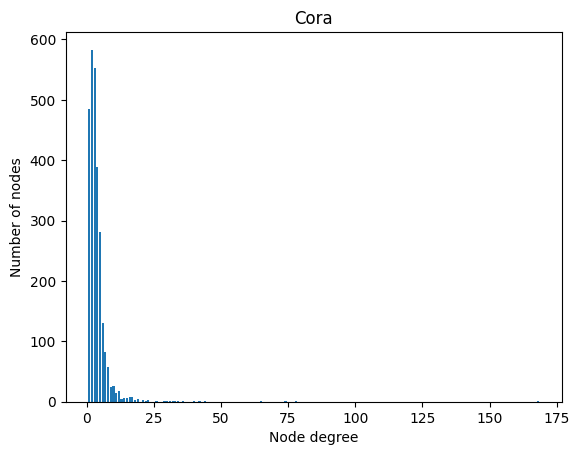

In [165]:
plot_node_degree(data1, "Cora")

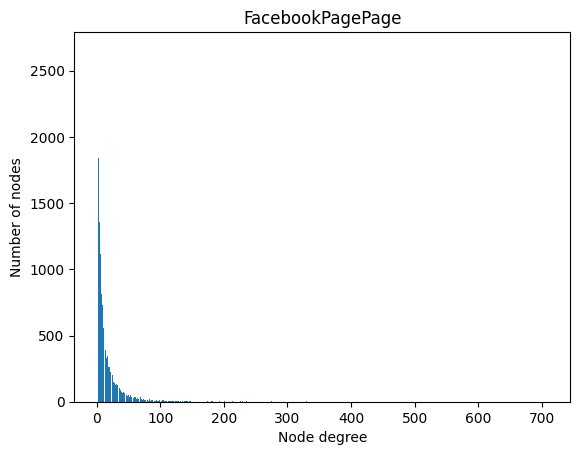

In [166]:
plot_node_degree(data2, "FacebookPagePage")

- Use GCN when you need a fast and simpler model, and where the (degree-normalized) neighbors are roughly equally important, ie, have roughly the same number of neighbors.
- Use GAT when you need a more complex model, and where the neighbors have varying importance, ie, have different number of neighbors.

Very roughly, in terms of the above plots (No. of nodes vs. Node degree):
- Use GAT when the plot is more *spread-out* $\quad \rightarrow \quad$ GAT gives better accuracy than GCN on Cora as its plot is slightly more *spread-out*.
- Use GCN when the plot is less *spread-out* (or concentrated) $\quad \rightarrow \quad$ GCN gives better accuracy than GAT on FacebookPagePage as its plot is slightly less *spread-out*.

## Message Passing Neural Network (MPNN) - Generalization of GNN 📟